.

<span style="color: #8B008B; font-family: Arial; font-size: 3em;">Sistema de recomendación de librerías Python</span>

 <span style="color:#4B0082; font-family: Arial; font-size: 2em;">José Pérez Yázquez</span>

---

# Introducción

El presente proyecto implementa una propuesta de recomendador de librerías Python, la idea es que dado un proyecto que estemos desarrollando, nos recomiende librerías que otros proyectos similares han usado. Para ello usa como "corpus" la BBDD por excelencia de código, **Github**, y como medida de similitud sus descripciones y las librerías que ya compartan.

El proyecto consta de dos fases, en la primera de ellas obtendremos todos los metadatos de los proyectos usando la API Rest de Github y en la segunda parte, basándonos en esos metadatos construiremos el sistema de recomendación 



        

# Carga y procesamiento de datos
        

Esta fase se divide a su vez en tres subfases:
 1. Recopilación de la información de los proyectos
 2. Clonado de los proyectos
 3. Procesamiento de los proyectos clonados

## 1. Recopilación de la información de los proyectos

Usando la API Rest de Github descarga la información, metadatos, de todos los proyectos que cumplen una serie de criterios, estos serán los siguientes:
  - Identificados como proyectos Python
  - Creado entre el 1 de Enero de 2012 y hasta la fecha actual
  - Con un mínimo de 10 estrellas

Toda la información es almacenada en MongoDB concretamente en una colección llamada **projects** de una BD llamada **github**, la información almacenada es la siguiente:
 - id: 
 - name
 - full_name
 - created_at
 - git_url
 - description
 - language
 - stars
 - done: Se usa a nivel interno, indica si un proyecto está procesado, esto es identificados las librerías que usa y el fichero README cargado, en los puntos siguientes se detallan estos dos datos
 - readme_txt: Almacenará el texto de los ficheros README de los proyectos, será la información base para el sistema de recomendación
 - library: Lista con las librerías que el proyecto usa, en principio estará vacía y se alimentará cuando se procese el proyecto
 - raw_data: toda la información del proyecto sin procesar por si más adelante es necesario algún dato que en estos momentos no parece relevante

Cuando se usa la API de Github sin autenticación existen una serie de límites que no podemos superar, el primero es que el número máximo de resultados que cualquier consulta puede devolver
es de 1000, para salvar este impedimento, vamos a realizar sucesivas consultas restringiendo las llamadas a un solo día del intervalo que vamos a cubrir.

Por otra parte, existe otra restricción en el uso de la API, el número de llamadas por minuto está limitado a 60, podríamos incrementar esta cantidad si las llamadas son autenticadas,
esto es usar por ejemplo un "client ID" y "secret"  como partes de la consulta, pero vamos abordar una estrategia diferente. Se irán realizando las consultas sin atender a los límites y cuando ese límite se supere, se suspenderá el proceso durante 61 segundos y posteriormente se reanudará
por el punto en el que iba.

Si se desea consultar los límites comentados, podemos hacer una consulta, por ejemplo usando curl

curl -i https://api.github.com/users/octocat

HTTP/1.1 200 OK
Date: Mon, 01 Jul 2013 17:27:06 GMT
Status: 200 OK
X-RateLimit-Limit: 60
X-RateLimit-Remaining: 56
X-RateLimit-Reset: 1372700873


En la cabecera de la respuesta nos muestra los límites con el valor actual:

 - **X-RateLimit-Limit**       Número máximo de solicitudes que se le permite hacer por hora.
 - **X-RateLimit-Remaining**   Número de solicitudes restantes en la ventana de límite de velocidad actual.
 - **X-RateLimit-Reset**       Hora a la que se restablece la ventana de límite de velocidad actual en segundos UTC.

En primer lugar vamos a cargar las librerías necesarias para esta fase del proyecto

In [8]:
import requests
import json
import os
from time import sleep
from pymongo import MongoClient
from datetime import date, timedelta

A continuación vamos a definir una serie de constantes que serán usadas en el código, de esta manera podremos cambiar facilimente alguno de estos valores.
El significado de cada una de ellas es el siguiente:
 - MIN_STARTS: Número mínimo de estrellas que tiene que tener un proyecto para ser considerado
 - START_DATE: Fecha de inicio del intervalo, haciendo referencia a la fecha de creación del proyecto en Github
 - END_DATE: Fecha de fin del intervalo
 - URL_PATTERN: Patrón de la URL para la consulta a la API de Github, podemos ver que filtramos por lenguaje (Python), por fecha de creación (la suministraremos durante la ejecución) y por numero de estrellas (referido a la constante comentada anteriormente).
 - ROOT_PATH: Directorio raiz donde clonaremos los repositorios
 - CLONE_COMMAND: Comando usado para clonar los repositorios

In [10]:
MIN_STARTS = 10
START_DATE = date(2012, 1, 1)
END_DATE = date(2017, 8, 28)
URL_PATTERN = 'https://api.github.com/search/repositories?q=language:Python+created:{0}+stars:>={1}&type=Repositories'
ROOT_PATH = "d:/tmp/"
CLONE_COMMAND = "git clone {0} {1}"

Como se ha comentado anteriormente, vamos a usar MongoDB como tecnología de persistencia, vamos a definir una funcion que nos devuelva una referencia a la colección de proyectos con la que estamos trabajando.

In [3]:
def get_repository():
    client = MongoClient('localhost', 27017)
    db = client.github2
    return db.projects

La siguiente función es la que realmente hace las llamadas a la API, tendrá como entrada la fecha de creación de los proyectos, usará la URL que hemos definicdo como constante.

In [4]:
def get_projects_by_date(date):
    print("Processing date ", date)
    url_pattern = URL_PATTERN
    url = url_pattern.format(date, MIN_STARTS)
    response = requests.get(url)
    if (response.ok):
        response_data = json.loads(response.content.decode('utf-8'))['items']
        for project in response_data:
            insert_project(project)
    else:
        response.raise_for_status()

A continuanción definimos otra función auxiliar, que dada la información de la respuesta de la API, selecciona la que vamos a necesitar y lo inserta como un documento Mongo. Adicionalmente crea las propiedades mencionadas previamente.

In [6]:
def insert_project(github_project):
    if projects.find_one({"id": github_project["id"]}):
        print("Project {0} is already included in the repository".format(github_project["name"]))
    else:
        project = {
            'id': github_project["id"],
            'name': github_project["name"],
            'full_name': github_project["full_name"],
            'created_at': github_project["id"],
            'git_url': github_project["git_url"],
            'description': github_project["description"],
            'language': github_project["language"],
            'stars': github_project["stargazers_count"],
            'done': False,
            'readme_txt': "",
            'library': [],
            'raw_data': github_project
        }
        projects.insert(project)

Finalmente ejecutamos el programa que, usando las funciones anteriormente definidas, descarga la información de los proyectos y la inserta en la BBDD, podemos observar que descompone las llamadas para traer en cada una de ellas solo los proyectos de un determinado dia y que *"gestiona"* las restricciones que tenemos en cuanto a llamada en la ventana de tiempo actual. En primer lugar recuperamos la colección en la que vamos a insertar los proyectos.

In [ ]:
projects = get_repository()

Y cargamos los proyectos en la colección

In [ ]:
for project_create_at in [START_DATE + timedelta(days=x) for x in range((END_DATE - START_DATE).days + 1)]:
    try:
        get_projects_by_date(project_create_at)
    except:
        print(">> Reached call limit, waiting 61 seconds...")
        sleep(61)
        get_projects_by_date(project_create_at)

En este punto tendriamos cargada toda la información que necesitamos de Github.

 ## 2. Clonado de los proyectos

Para analizar las librerias que un proyecto utiliza, un camino podría ser buscar los ficheros **requirements** de cada proyecto y parsear esa información, pero dicho fichero no está presente en una gran cantidad de proyectos, por lo que se ha optado por un camino un poco más **radical**.

Usando la información cargada en el paso anterior, fundamentalmente la propiedad **git_url**, vamos a clonar cada proyecto en local para posteriormente procesarlos.

**NOTA**: Filtramos por los proyectos que no están procesados y nos aseguramos que el directorio no existe, porque este código, dado que puede tardar bastante, lo vamos a ejecutar en diferentes momentos.

In [11]:
os.chdir(ROOT_PATH)

for project in projects.find({'done':False}):
    path = ROOT_PATH + "/" + str(project["id"])
    if not os.path.isdir(path):
        os.system(CLONE_COMMAND.format(project["git_url"], project["id"]))

NameError: name 'projects' is not defined

En este punto tendríamos clonados todos los repositorios con los que construiremos el sistema de recomendación.

## 3. Procesamiento de los proyectos clonados

Comenzamos esta etapa definiendo una función que dado un fichero python (extenxión **.py**), lo recorre linea por linea y, usando expresiones regulares, buscamos todas las librerias que se estén usando.
Almacenamos esta lista en la propiedad **library** del proyecto en cuestión.

In [ ]:
def process_python_file(project, file_path):
    def add_to_list(item):
        if not item in library:
            library.append(item)

    library = project['library']
    pattern = '(?m)^(?:from[ ]+(\S+)[ ]+)?import[ ]+(\S+)[ ]*$'
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            match = re.search(pattern, line)
            if match:
                if match.group(1) != None:
                    add_to_list(match.group(1))
                else:
                    add_to_list(match.group(2))
    project['library'] = library
    projects.update({'_id': project['_id']}, {"$set": project}, upsert=False)

Por otra parte, definimos también una función que dado un fichero README lo lee y lo almacena en la propiedad **readme_txt**

In [ ]:
def process_readme_file(project, file_path):
    with open(file_path, 'r') as f:
        project['readme_txt'] = f.read()
        projects.update({'_id': project['_id']}, {"$set": project}, upsert=False)

Finalmente recorremos los repositorios no procesados, como comentabamos anteriormente este proceso podría ser necesario lanzarlo reiteradas veces, para cada repositorio analizamos su fichero README y cada uno de los ficheros Python para extraer las librerías.

In [ ]:
for project in projects.find({'done':False}):
    try:
        print(".",end="")
        path = ROOT_PATH.format(project["id"])
        if os.path.isdir(path):
            print("Processing project: ", project["id"])
            project['done'] = True
            projects.update({'_id': project['_id']}, {"$set": project}, upsert=False)
            for root, dirs, files in os.walk(path):
                for file in files:
                    try:
                        if file.endswith(".py"):
                            process_python_file(project, os.path.join(root, file))
                        else:
                            if file.lower().startswith("readme."):
                                process_readme_file(project, os.path.join(root, file))
                    except:
                        pass
    except:
        print("Error procesing project {0} [{1}] - {2}".format(project['id'], project['name'], sys.exc_info()[0]))

En este punto, tendríamos una colección MongoDB con cada uno de los proyectos de nuestro **pre-corpus** con la lista de librerías que cada proyecto usa así como su descripción **extendida** extraida de su fichero READMA. Estaríamos en disposición por tanto de comenzar la implementación de nuestro recomendador.

# Implementación del recomendador

## Principios teóricos

Para identificar la similitud entre los proyectos basándonos en su descripción, entendiéndose como tal su fichero README, utilizamos el "análisis semántico latente" (LSA, usando la abreviatura en inglés), que es una técnica ampliamente utilizada en el procesamiento del lenguaje natural. LSA transforma cada texto en un vector, en un espacio de características. En nuestro caso, las características son palabras que ocurren en las descripciones. A continuación, se crea una matriz que contiene todos los vectores: las columnas representan las descripciones de los proyectos y las filas representan palabras únicas. Por consiguiente, el número de filas puede ascender a decenas de miles de palabras. 

Con el fin de identificar las características relevantes de esta matriz, usaremos la "descomposición de valores singulares" (SVD, usando la abreviatura en inglés), que es una técnica de reducción de dimensión, se utiliza para reducir el número de líneas -palabras-, manteniendo y resaltando la similitud entre columnas-descripción -. La dimensión de esta matriz de aproximación se establece mediante un hiperparámetro que es el número de temas, comúnmente llamado como tópicos. En este marco, un tópico consiste en un conjunto de palabras con pesos asociados que definen la contribución de cada palabra a la dirección de este tópico. Basándose en esta matriz de aproximación de baja dimensión, la similitud entre dos columnas -descripciones- se calcula utilizando el coseno del ángulo entre estos dos vectores.


# Implementación del recomendador

   ## Importación de librerías y módulos
        

Comenzamos importando las librerías que vamos a usar en esta fase del proyecto.

In [36]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [37]:
import nltk
import json
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim import corpora, models, similarities, matutils

### Carga de los datos

Definimos una funcion para cargar los datos de los proyectos, entre los datos a cargar está el fichero **readme** y las librerías usadas, datos que serán los que usemos para calcular las similitudes entre los proyectos.

In [38]:
def load_projects3(max_projects=90000):
    projects = get_repository()
    projects = []

    for project in projects.find({'done': True}).limit(1000):
        project = dict()
        project['id'] = project['id']
        project['name'] = project['name']
        project['date'] = project['created_at']
        project['libraries'] = project['library']
        project['readme_txt'] = project['readme_txt']
        projects.append(project)

    return projects


def load_projects(max_projects=90000):
    def load_plot_summaries():
        plot_summaries_file = open("data/plot_summaries.txt", "r", encoding="utf8")
        # plot_summaries_file = open("data/plot_summaries.txt", "r", encoding="utf8")
        plot_summaries = dict()
        for plot_readme_txt_line in plot_summaries_file:
            plot_readme_txt_data = plot_readme_txt_line.split('\t')
            # Summaries structure
            # [0] Wikipedia project ID
            # [1] Summary plot
            plot_readme_txt = dict()
            plot_readme_txt['id'] = plot_readme_txt_data[0]
            plot_readme_txt['readme_txt'] = plot_readme_txt_data[1]

            plot_summaries[plot_readme_txt['id']] = plot_readme_txt

        return plot_summaries

    print("Cargando datos de proyectos...")

    plot_summaries = load_plot_summaries()

    metadata_file = open("data/movie.metadata.tsv", encoding="utf8")
    # metadata_file = open("data/project.metadata.tsv", "r", encoding="utf8")
    projects = []

    projects_count = 0

    for metadata_line in metadata_file:
        project_metadata = metadata_line.split('\t')
        id = project_metadata[0]

        # Añadimos la proyecto solo si tiene sinopsis, incluimos una lista con las claves de los generos
        if (id in plot_summaries) & (projects_count < max_projects):
            projects_count += 1
            project = dict()
            project['id'] = id
            project['name'] = project_metadata[2]
            project['date'] = project_metadata[3]
            project['libraries'] = list(json.loads(project_metadata[8].replace("\"\"", "\"").replace("\"{", "{").replace("}\"", "}")).values())
            project['readme_txt'] = plot_summaries[id].get('readme_txt')
            projects.append(project)

    print("Número de proyectos cargadas:", len(projects))

    return projects

Usando la funcíon anterior cargamos los datos, dado que el proceso es bastante pesado solo cargaremos un subconjunto de las mismas

In [39]:
projects = load_projects(1000)

Cargando datos de proyectos...
Número de proyectos cargadas: 1000


## Preprocesamiento de las descripciones
 
A continuación procesamos las sinopsis, quedándonos con las palabras diferentes que encontramos en cada una de ellas, en primer lugar, eliminamos puntuaciones y palabras irrelevantes como nombres personales y palabras comunes que no aportan signficado (denominados "stop words"). Esto evitará que se formen tópicos en torno a ellos

Además, utilizamos el stemmer Snowball, también llamado Porter2 stemmer, para detectar palabras similares presentes en diferentes formatos (eliminar sufijo, prefijo, etc.). Snowball es un lenguaje desarrollado por M.F. Porter, para definir de forma eficiente stemmers. Este algoritmo de derivación es el más utilizado en el dominio del procesamiento del lenguaje natural.

Para hacer el procesamietno usaremos la librería nltk( Natural Language Toolkit) proporciona un gran número de métodos que cubren diferentes temas en el dominio de los datos del lenguaje humano, como la clasificación, derivación, etiquetado, análisis y razonamiento semántico.



In [40]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

Creamos una función que dado un texto lo descompone en las palabras con significado que lo componen

In [41]:
def get_words(text):
    def add_word(word):
        word = word.lower()
        if word not in stop_words:
            words.append(stemmer.stem(word))

    words = []
    for chunk in nltk.ne_chunk(nltk.pos_tag(tokenizer.tokenize(text))):
        # nltk.word_tokenize    devuelve la lista de palabras que forman la frase (tokenización)
        # nltk.pos_tag          devuelve el part of speech (categoría) correspondiente a la palabra introducida
        # nltk.ne_chunk         devuelve la etiqueta correspondiente al part of speech (POC)
        try:
            if chunk.label() == 'PERSON':
                # PERSON es un POC asociado a los nombres propios, los cuales no vamos a añadir
                pass
            else:
                for c in chunk.leaves():
                    add_word(c[0])
        except AttributeError:
            add_word(chunk[0])

    return words

Creamos una función que aplica la función anterior a los resúmenes de todos los proyectos.

In [42]:
def get_global_texts(projects):
    print("Extrayendo palabras de los textos...")
    global_texts = []

    [global_texts.append(get_words(project['readme_txt'])) for project in projects]

    return global_texts

Finalmente ejecutamos la función que acabamos de definir, tendremos una lista de listas, en la que para cada proyecto tendremos las palabras que lo definen.

In [43]:
global_texts = get_global_texts(projects)

Extrayendo palabras de los textos...


A modo de ejemplo, mostramos las 5 primeras entradas del primer proyecto

In [44]:
global_texts[0][:5]

['set', 'second', 'half', '22nd', 'centuri']

## Creación del diccionario
 
El diccionario está formado por la concatenación de todas las palabras que aparecen en algún resumen de alguno de los proyectos. Básicamente esta función mapea cada palabra única con su identificador. Es decir, si tenemos N palabras, lo que conseguiremos al final es que cada proyecto sea representada mediante un vector en un espacio de N dimensiones.
 
Para ello, partiendo de la lista creada en el paso anterior, usaremos la función **corpora** del paquete **gensim**.

El diccionario consiste en una concatenación de palabras únicas de todas las sinopsis. Gensim es una biblioteca eficiente para analizar la similitud semántica latente entre documentos.
Este módulo implementa el concepto de Diccionario - un mapeo entre palabras y
sus entes ids.

Los diccionarios pueden ser creados a partir de un corpus y luego pueden ser
frecuencia del documento (eliminación de palabras comunes mediante el método func: `Dictionary.filter_extremes`),
guardado / cargado desde el disco (vía: func: `Dictionary.save` y: func:` Dictionary.load`), fusionado
con otro diccionario (: func: `Dictionary.merge_with`) etc.

In [45]:
dictionary = corpora.Dictionary(global_texts)
dictionary

**Esta función asigna palabras únicas con sus ids. En nuestro caso, la longitud del diccionario es igual a 15035 palabras lo que significa que cada sinopsis será representada a través de un espacio vectorial de 15035 dimensiones.**

Mostramos las primeras 10 entradas

In [46]:
list(itertools.islice(dictionary.token2id.items(), 0, 10))

[('verifi', 9375),
 ('journey', 1508),
 ('characterist', 4178),
 ('decid', 41),
 ('deni', 1238),
 ('rebus', 8963),
 ('smarter', 7924),
 ('painkil', 4744),
 ('gutter', 5966),
 ('kungfu', 4416)]

## Creación del Corpus

Crearemos un corpus con la colección de todos los resúmenes previamente pre-procesados y transformados usando el diccionario. Vamos a convertir los textos a un formato que gensim puede utilizar, esto es, una representación como bolsa de palabras (BoW). Gensim espera ser alimentado con una estructura de datos de corpus, básicamente una lista de "sparce vectors", estos constan de pares (id, score), donde el id es un ID numérico que se asigna al término a través de un diccionario. 

In [47]:
corpus = [dictionary.doc2bow(text) for text in global_texts]

A modo de ejemplo, mostramos las 5 primeras entradas del primer proyecto

In [48]:
corpus[0][:5]

[(0, 1), (1, 2), (2, 2), (3, 1), (4, 1)]

## Creación del TFID

Un alto peso en tf-idf se alcanza por una alta frecuencia en un Documento y una baja frecuencia en toda la colección de documentos; los pesos tienden a filtrar términos comunes. Para la creación de este corpus, vamos a usar la función **TfidfModel** del objeto **models** (perteneciente a la librería *gemsim*).


In [49]:
def create_tfidf(corpus):
    print("Creación del Modelo Espacio-Vector Tf-Idf")
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    return corpus_tfidf


corpus_tfidf = create_tfidf(corpus)

Creación del Modelo Espacio-Vector Tf-Idf


En corpus tenemos, para cada project, una lista con sus palabras y el tfidf de cada una. Mostramos el primer elemento

In [50]:
corpus_tfidf[0]

[(0, 0.05517368973772726),
 (1, 0.06646112247334413),
 (2, 0.09689620362443847),
 (3, 0.03198114085380403),
 (4, 0.03720343814725363),
 (5, 0.04777845053878821),
 (6, 0.04879392738122038),
 (7, 0.06506448867988254),
 (8, 0.0804972778925506),
 (9, 0.04167292010782611),
 (10, 0.08193516188229652),
 (11, 0.0536740383863579),
 (12, 0.03974090052505921),
 (13, 0.10868959181823236),
 (14, 0.07411751553604372),
 (15, 0.04184194087364232),
 (16, 0.06411059481230273),
 (17, 0.06093870065341667),
 (18, 0.03860297613867702),
 (19, 0.10868959181823236),
 (20, 0.03897321510278386),
 (21, 0.3260687754546971),
 (22, 0.059354377596806694),
 (23, 0.05517368973772726),
 (24, 0.02733497338910238),
 (25, 0.3705875776802186),
 (26, 0.060785766671958785),
 (27, 0.018276360014157507),
 (28, 0.03501892582577447),
 (29, 0.03186148681718297),
 (30, 0.024858497250395302),
 (31, 0.07245972787882159),
 (32, 0.08687704024905744),
 (33, 0.12552582262092696),
 (34, 0.07597076446447),
 (35, 0.06506448867988254),
 (36,

Si queremos saber que palabra es cada uno de estos términos podemos consultar el diccionario

In [51]:
print(dictionary[0],",",dictionary[1],",", dictionary[2])

intent , attack , author


## Creación del Modelo LSI

Para ello vamos a definir una función auxiliar y posteriormente la invocaremos, además de crear el modelo LSI, vamos a usarlo para crear la matriz de similitudes. Antes de nada vamos a definir una serie de constantes para controlar el proceso.
 
* **TOTAL_LSA_TOPICS**
Limita el numero de terminos, por supuesto tiene que ver con el tamaño de la muestra, mientras más proyectos tengamos mas terminos tendremos y por tanto la reduccion seria mayor, estamos clusterizando las proyectos en TOTAL_TOPICOS_LSA clusters
 
* **SIMILARITY_THRESHOLD** Umbral de similitud que se debe superar para que dos proyectos se consideren similares

* **LIBRARY_COINCIDENCE_RATE** porcentaje en el que incrementaremos la similitud de los proyectos por cada librería que dos proyectos tengan en común

 


### Determinación del número de topicos

*Como se mencionó anteriormente, LSA busca identificar un conjunto de topicos relacionados las descripciones de los proyectos. El número de estos temas N es igual a la dimensión de la matriz de aproximación resultante de la técnica de reducción de dimensión SVD. Este número es un hiperparámetro que se debe ajustar cuidadosamente, es el resultado de la selección de los N valores singulares más grandes de la matriz del corpus tf-idf. Estos valores singulares se pueden calcular de la siguiente manera:*

En primer lugar usando la función **corpus2dense** , convertimos el corpus en una matriz np densa (los documentos serán columnas). Esta función necesita el número de características (parámetro **num_terms**), porque la dimensionalidad no se puede deducir solo con el corpus. Adicionalmente vamos a suministrar el numero de documentos (parámetro **num_docs**), para que el algoritmo sea más eficiente.

*Nota: La función inversa de **corpus2dense** es **Dense2Corpus** *

In [52]:
num_docs = len(global_texts)
num_docs

1000

In [53]:
num_terms = len(dictionary)
num_terms

12566

In [54]:
numpy_matrix = matutils.corpus2dense(corpus, num_terms=num_terms, num_docs=num_docs)
numpy_matrix

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  2.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]], dtype=float32)

In [55]:
svd = np.linalg.svd(numpy_matrix, full_matrices=False, compute_uv=False)
svd

array([ 198.09124756,   72.27992249,   68.53360748,   65.42533875,
         61.31890106,   59.96660614,   57.51701736,   55.00877762,
         53.73410416,   52.5979538 ,   52.25812531,   51.14103317,
         49.8937912 ,   48.5202446 ,   48.18895721,   47.66302109,
         47.24345016,   46.74636078,   46.13379669,   45.15121078,
         44.82839966,   44.02625656,   43.25774002,   42.86566162,
         42.29089737,   41.92856216,   41.75440979,   41.18707657,
         40.96023941,   40.80237198,   40.1966362 ,   39.9087944 ,
         39.65435791,   39.13255692,   39.08746338,   38.65299606,
         38.23283386,   37.65267563,   37.57136154,   37.40861893,
         37.3235054 ,   36.93718719,   36.63299942,   36.40248489,
         36.06575775,   35.85059738,   35.53202057,   35.39121628,
         35.13446808,   34.80001068,   34.66302872,   34.45415497,
         34.29391861,   33.94166183,   33.87244034,   33.69962311,
         33.35720444,   33.18489838,   33.00522995,   32.94475

In [56]:
s

array([ 3.07966828,  2.8681531 ,  2.17462349,  2.02355862,  1.73205078,
        1.6565845 ,  1.41421354,  1.19722176,  1.13487995], dtype=float32)

In [59]:
svd[0]

198.09125

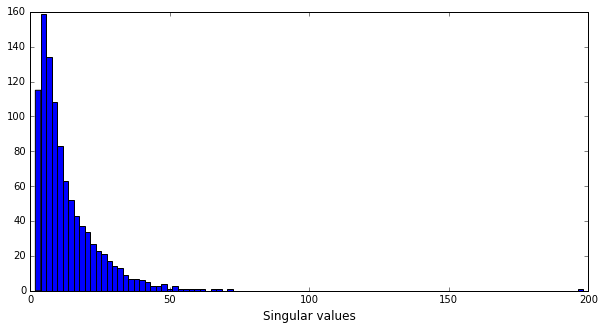

In [76]:
plt.figure(figsize=(10,5))
plt.hist(svd, bins=100)
plt.xlabel('Singular values', fontsize=12)
plt.show()

ValueError: x and y must have same first dimension

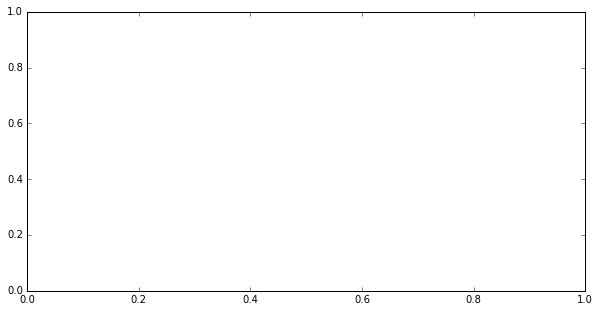

In [77]:
plt.figure(figsize=(10,5))
plt.plot(range(0,101,5), svd, '*-')
plt.xlabel('Threshold of singular values', fontsize=12)
plt.ylabel('Number of topics', fontsize=12)

Finalmente asignamos el valor a una constante, junto a los otros dos parámetros comentados anteriormente.

In [65]:
TOTAL_LSA_TOPICS = 5
SIMILARITY_THRESHOLD = 0.6
LIBRARY_COINCIDENCE_RATE = 0.01

In [72]:
lsi.projection.s

array([ 4.53701626,  1.93106029,  1.79900184,  1.75782104,  1.65492278])

In [75]:
# write out coordinates to file
fcoords = open("data/coords.csv", 'wb')
for vector in lsi[corpus]:
    if len(vector) != 2:
        continue
    fcoords.write("%6.4f\t%6.4f\n" % (vector[0][1], vector[1][1]))
fcoords.close()

## Creación del modelo LSA: Latent Semantic Analysis

In [66]:
def create_lsi_model(corpus_tfidf, dictionary, total_lsa_topics):

    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=total_lsa_topics)
    similarity_matrix = similarities.MatrixSimilarity(lsi[corpus_tfidf])
    return lsi, similarity_matrix


(lsi, similarity_matrix) = create_lsi_model(corpus_tfidf, dictionary, TOTAL_LSA_TOPICS)

Definimos la función auxiliar que dado un proyecto, nos determina la lista de proyectos que superan el umbral de similitud, adicionalmente vamos a bonificar los proyectos que compartan librerías con el proyecto analizado, de este modo, además del indice de similitud, vamos a sumar el valor de la constante LIBRARY_COINCIDENCE_RATE por cada librería coincidente. Para cada proyecto que supere el umbral, almacenaremos el índice dentro de la matriz de proyectos, para localizarla posteriormente, y el grado de similitud

In [67]:
def get_similarities(doc, libraries):
    def genre_score(libraries_to_compare):
        common_libraries = len(set(libraries).intersection(libraries_to_compare))
        return common_libraries * LIBRARY_COINCIDENCE_RATE

    project_similarities = []

    vec_bow = dictionary.doc2bow(get_words(doc))

    vec_lsi = lsi[vec_bow]  # convert the query to LSI space

    similarities = similarity_matrix[vec_lsi]
    similarities = sorted(enumerate(similarities), key=lambda item: -item[1])

    for sim in similarities:
        similarity_project = projects[int(sim[0])]
        similarity_score = sim[1] + genre_score(similarity_project["libraries"])
        if similarity_score > SIMILARITY_THRESHOLD:
            project_similarities.append((similarity_project, similarity_score))
    return(project_similarities)

A modo de ejemplo, vamos a determinar los proyectos similares a uno dado.

In [68]:
project_similarities = get_similarities("A murder woman", ["Mystery", "Drama", "Biographical film"])

Y las mostramos

In [69]:
for similarity in project_similarities:
    print("Project: {0}: - Similarity: {1}".format(similarity[0]["name"], similarity[1]))

Project: Forgotten Babies: - Similarity: 0.9671334028244019
Project: Eyes of a Stranger: - Similarity: 0.9762570357322693
Project: Ulle Veliye: - Similarity: 0.965829074382782
Project: First Action Hero: - Similarity: 0.9619616270065308
Project: Hell to Pay: - Similarity: 0.9670919871330261
Project: Female Prisoner Scorpion: Beast Stable: - Similarity: 0.9650445079803467
Project: Amador: - Similarity: 0.9643123841285706
Project: The Lone Wolf Meets a Lady: - Similarity: 0.9718817663192749
Project: The Vigilantes Return: - Similarity: 0.9516085386276245
Project: The Stoker: - Similarity: 0.9581751918792725
Project: Lady Cocoa: - Similarity: 0.9518472051620483
Project: Daughter of the Nile: - Similarity: 0.9501634335517883
Project: A Question of Silence: - Similarity: 0.9432544803619385
Project: Hob wa Dumoo`: - Similarity: 0.9407556748390198
Project: Sambizanga: - Similarity: 0.9392972683906555
Project: Café Cantante: - Similarity: 0.928276777267456
Project: The Tiger's Trail: - Similar